# Installation
CNGI documentation is located here:
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide

Refer to the Visibility Overview example notebook for an introduction to the basics of creating and handling visibility data.


In [1]:
import os

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install cngi-prototype==0.0.40")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


In [2]:
from cngi.conversion import convert_ms

# cngi.dio.read_vis is normally used for data previously converted
# but for convenience, convert_ms will return a list of xds's after the conversion process
[global_xds, vis_xds] = convert_ms('sis14_twhya_calibrated_flagged.ms')

processing sis14_twhya_calibrated_flagged.ms 
writing global partition
meta data processing time  0.6505770683288574
**********************************
Processing ddi 0
Selecting and sorting time  0.02534794807434082
n_time: 410   n_baseline: 210   n_chan: 384   n_pol: 2  chunking:  [100, 400, 20, 1]  batchsize:  100
Completed ddi 0  process time  19.008654356002808
**********************************


# Channel Averaging

The channel averaging function looks for all data variables in the dataset with a channel dimension and averages by the specified bin width.  The returned dataset will have a different channel dimension size.

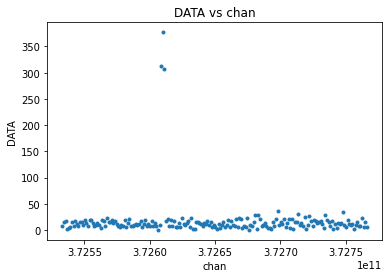

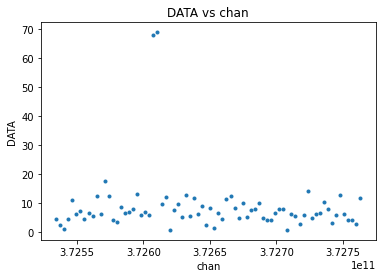

In [3]:
from cngi.vis import chanaverage, visualize

# average 5 channels of original unflagged data
avg_xds = chanaverage(vis_xds, width=5)

# compare the original to the channel averaged
visualize(vis_xds.DATA[30,0,:,0], 'chan')
visualize(avg_xds.DATA[30,0,:,0], 'chan')

In [4]:
# confirm new channel dimension after averaging
print(dict(vis_xds.dims))
print(dict(avg_xds.dims))

{'baseline': 210, 'chan': 384, 'pair': 2, 'pol': 2, 'receptor': 2, 'spw': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 76, 'pair': 2, 'pol': 2, 'receptor': 2, 'spw': 1, 'time': 410, 'uvw_index': 3}


Since every variable with a channel dimension in the dataset is averaged, this will also include the FLAG variable.  FLAG is a boolean type with values of 0 or 1 that are averaged over the width, resulting in a decimal number.  The result is then typcast back to boolean, which is the same as just rounding up.

Long story short, if any channel in the width is flagged, the resulting averaged channel will also be flagged

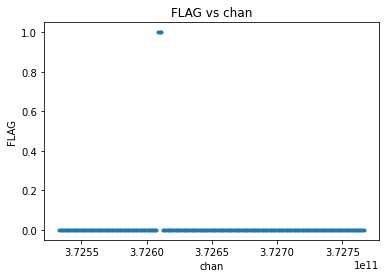

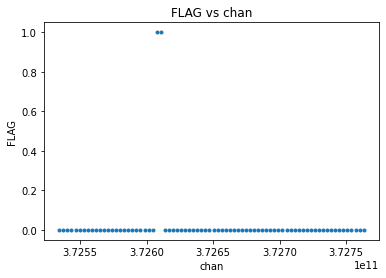

In [5]:
# compare the original flags to the channel averaged flags
visualize(vis_xds.FLAG[30,0,:,0], 'chan')
visualize(avg_xds.FLAG[30,0,:,0], 'chan')

One might want to apply flags before channel averaging

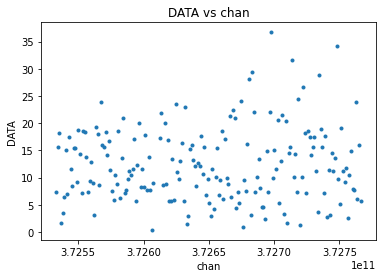

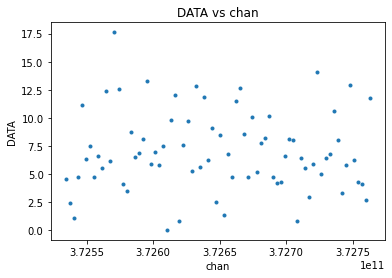

In [6]:
from cngi.vis import applyflags

flg_xds = applyflags(vis_xds, flags=['FLAG'])
avg_flg_xds = chanaverage(flg_xds, width=5)

visualize(flg_xds.DATA[30,0,:,0], 'chan')
visualize(avg_flg_xds.DATA[30,0,:,0], 'chan')

Or apply flags after channel averaging

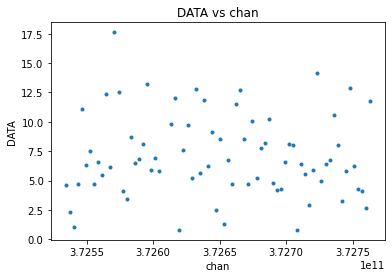

In [7]:
flg_avg_xds = applyflags(avg_xds, flags=['FLAG'])

visualize(flg_avg_xds.DATA[30,0,:,0], 'chan')

There is a small difference of two points, made more clear when we overlay the plots

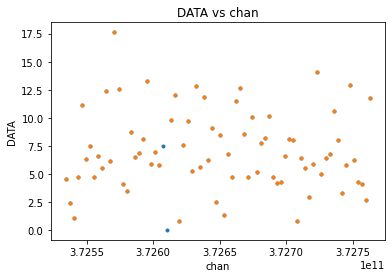

In [8]:
visualize(avg_flg_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visualize(flg_avg_xds.DATA[30,0,:,0], 'chan', overplot=True)

# Time Averaging

The time averaging function looks for all data variables in the dataset with a time dimension and averages by the specified bin width.  Spanning across states within a scan, scans of a each state, or both yields different results.  The returned dataset will have a different time dimension size.

First let's see the relationship between scans, states, and time in this data

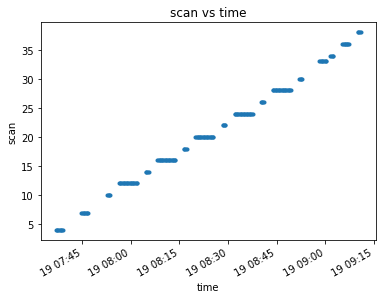

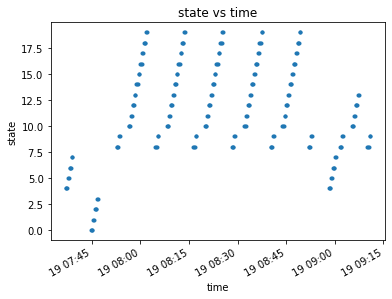

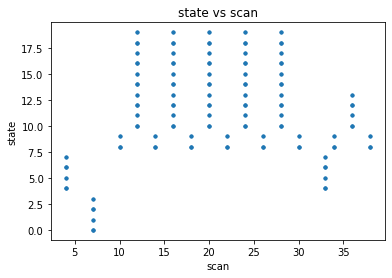

In [9]:
from cngi.vis import visualize

visualize(vis_xds.scan, 'time')
visualize(vis_xds.state, 'time')
visualize(vis_xds.state, 'scan')

Let's start by not spanning anything.  The comparison plots will look at all times across baseline 100, channel 100, and polarization 0 (random selection)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


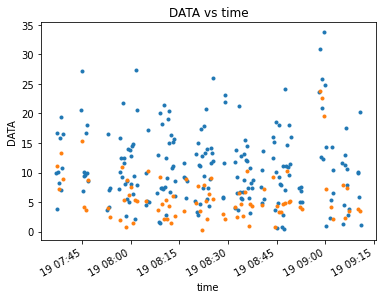

In [20]:
from cngi.vis import timeaverage

# average 7 time steps, don't span anything (separate by scan and state)
avg_xds = timeaverage(vis_xds, width=7, timespan='none')

# compare the original to the time averaged
visualize(vis_xds.DATA[:,100,100,0], 'time', drawplot=False)
visualize(avg_xds.DATA[:,100,100,0], 'time', overplot=True)

In [17]:
# confirm new channel dimension after averaging
print(dict(vis_xds.dims))
print(dict(avg_xds.dims))

{'baseline': 210, 'chan': 384, 'pair': 2, 'pol': 2, 'receptor': 2, 'spw': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pair': 2, 'pol': 2, 'receptor': 2, 'time': 82, 'uvw_index': 3}


/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


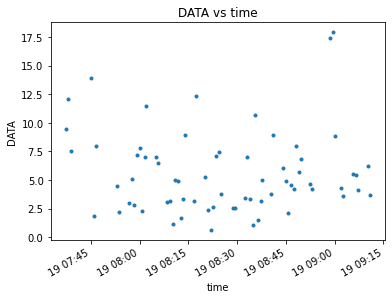

In [11]:
# average 7 time steps spanning states within each scan
state_avg_xds = timeaverage(vis_xds, width=7, timespan='state')

visualize(state_avg_xds.DATA[:,100,100,0], 'time')

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


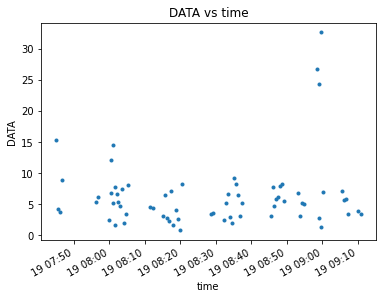

In [12]:
# average 7 time steps spanning all scans per state
scan_avg_xds = timeaverage(vis_xds, width=7, timespan='scan')

visualize(scan_avg_xds.DATA[:,100,100,0], 'time')

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


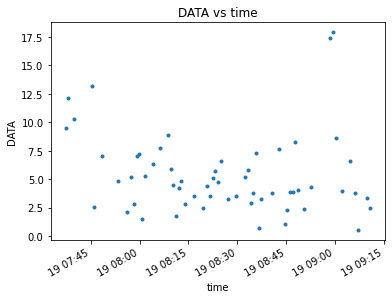

In [13]:
# average 7 time steps spanning all scans and states
both_avg_xds = timeaverage(vis_xds, width=7, timespan='both')

visualize(both_avg_xds.DATA[:,100,100,0], 'time')

We can inspect the change to scans over time as a result of the different spanning

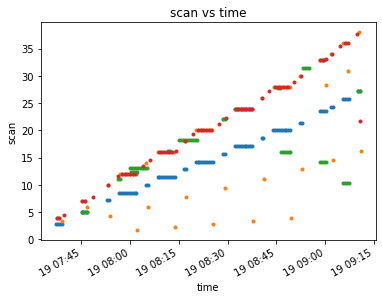

In [14]:
visualize(avg_xds.scan, 'time', drawplot=False)
visualize(state_avg_xds.scan, 'time', overplot=True, drawplot=False)
visualize(scan_avg_xds.scan, 'time', overplot=True, drawplot=False)
visualize(both_avg_xds.scan, 'time', overplot=True)

Flagging works the same way as in channel averaging.  Flags are averaged with all other data sharing the time axis.  They may be applied before or after time averaging.

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


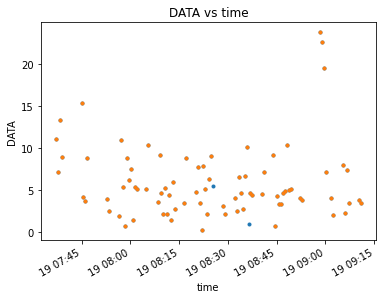

In [15]:
from cngi.vis import applyflags

avg_flg_xds = timeaverage(applyflags(vis_xds, flags=['FLAG']), width=5, timespan='both')
flg_avg_xds = applyflags(timeaverage(vis_xds, width=5, timespan='both'), flags=['FLAG'])

visualize(avg_flg_xds.DATA[:,100,100,0], 'time', drawplot=False)
visualize(flg_avg_xds.DATA[:,100,100,0], 'time', overplot=True)

# Channel Smoothing

Channel smoothing allows a variety of window shapes to be convolved across the channel dimension to smooth over changes from bin to bin. The standard CASA hanning smooth is supported as the default option.  The returned dataset will have the same dimensions as the original.

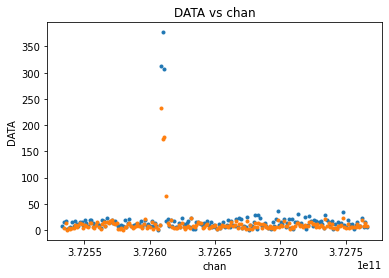

In [19]:
from cngi.vis import chansmooth

smooth_xds = chansmooth(vis_xds)

visualize(vis_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visualize(smooth_xds.DATA[30,0,:,0], 'chan', overplot=True)

chansmooth uses the scipy.signal package to set the window shape. Therefore, all the window functions supported by scipy are also supported here.  The size of the window width is configurable.

[https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)


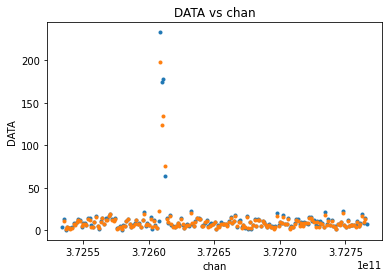

In [21]:
bohman_xds = chansmooth(vis_xds, type='bohman', size=7)

visualize(smooth_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visualize(bohman_xds.DATA[30,0,:,0], 'chan', overplot=True)

non-unity gains are also supported to amplify or attenuate the output

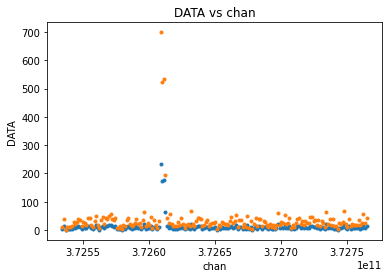

In [22]:
hann_xds = chansmooth(vis_xds, type='hann', size=5, gain=1.0)
amp_hann_xds = chansmooth(vis_xds, type='hann', size=5, gain=3.0)

visualize(hann_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visualize(amp_hann_xds.DATA[30,0,:,0], 'chan', overplot=True)